# Module 2: Generalized Linear Models II

In this tutorial with will fit LNP models with Maximum Likelihood Estimators (MLEs) (Part 3) and Maximum Aposteriori (MAP) (Part 4). This tutorial will introduce the concepts based on simulated neuronal responses. It will provide you witht the necessary experience to then work on real neuronal datasets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize as scipy_minimize
from scipy.special import factorial, gammaln

from utils import make_filter, convolution,convolution_new, minimize_mle, cost, hankel, hankel_new

References and extra reading:

GLM Tutorial from Jonathan Pillow : https://github.com/pillowlab/GLMspiketraintutorial

GLM Paper Pillow et al., Nature 2008: https://www.nature.com/articles/nature07140

Proof that GLMs (under certain conditions) are guaranteed to have convex loss functions : 
http://www.cns.nyu.edu/pub/lcv/paninski04b.pdf

Proof that STA is a linear estimate of the receptive field:
https://neurophysics.ucsd.edu/courses/physics_171/Chichilnisky2001.pdf


---
**Remember the solutions from the previous tutorial**

PMF of the Poisson distribution:

$p(y) = \frac{(r\Delta t)^y \exp(-r\Delta t)}{y!}$

Likelihood of a spike train consisting of $T$ timebins and $L$ trials in a homogenous Poisson process:

In a homogenous Poisson process, we assume that the spike counts in each timebin and trials are _independent_ , so the likelihood of a full spike train is simply the product of the probability of spike counts in each timebin and trial

$\begin{align}
 p(y_{1:T, 1:L}) &= \prod_{t=1}^T\prod_{i=1}^L p(y^i_t)\\
 &=  \prod_{t=1}^T\prod_{i=1}^L \frac{(r\Delta t)^{y^i_t} \exp(-r\Delta t)}{y^i_t!}
\end{align}$

The log likelihood, which is the quantity we maximise to obtain the ML estimator, is:

$ \begin{align}
\log p(y_{1:T, 1:L}) &= \sum_{t=1}^T\sum_{i=1}^L \log \frac{(r\Delta t)^{y^i_t} \exp(-r\Delta t)}{y^i_t!}\\
 &= \sum_{t=1}^T\sum_{i=1}^L y^i_t \log (r\Delta t) - r\Delta t - \log(y^i_t!)
 \end{align}$
 
The derivative of the log likelihood wrt $r$ and the ML estimator of $r$:

$ \begin{align}
\frac{d}{dr} \log p(y_{1:T, 1:L}) &= \sum_{t=1}^T\sum_{i=1}^L (\frac{y^i_t}{r} - \Delta t) = 0\\
 &=> \frac{\sum_{t=1}^T\sum_{i=1}^L y^i_t}{r} - LT\Delta t  = 0\\
 &=> \hat{r}_{\text{ML}} = \frac{\sum_{t=1}^T\sum_{i=1}^L y^i_t}{LT\Delta t} 
 \end{align}$

___
#### Linear-nonlinear (LNP) model
So far, we have seen a linear and a linear-nonlinear model where the spike count in a given timebin is dependent only on the stimulus in that timebin. To get more realistic spike counts on the model, the firing rate should be dependent on the stimulus-history. Hence, the input stimulus to the model at each timebin is now a vector of length $K$. $K$ is number of timebins in the past during which the neuron "integrates" the effect of the stimulus, weighted by the vector $\boldsymbol{\omega}$ of size $K$:

$z_t = \sum_{k=1}^K \omega_k x_{t-k} + b$

The operation described in the equation above is called a _convolution_ and the parameter $\boldsymbol{\omega}$ is the neuron's _receptive field_.

The firing rate vector across all timebins, $\mathbf{r}$, and responses, $\mathbf{y}$, in a linear-nonlinear Poisson (LNP) process for input stimulus $\mathbf{x}$ is given by:

$\begin{align}
\mathbf{z} &= \boldsymbol{\omega} * \mathbf{x} + b \\
\mathbf{r} &= \exp(\mathbf{z}) \\
\mathbf{y} &\sim Poisson(\mathbf{r})
\end{align}$


where $\boldsymbol{\omega}$ is the convolutional filter or receptive field, $b$ is a baseline offset, $*$ is the convolution operation.  

You implemented such a model and compared the true firing rate to the PSTHs. You furthermore observed that the STA gave a decent estimate given you had sufficient timebins per trial.

#### Spike triggered average (STA)
The STA is the stimulus shape, that on average, elicits a response. It is a linear estimate of the convolution filter. To calculate the STA we average over all the stimulus vectors (of a fixed length) that preceded a timebin, and weighted by the number of spikes in that timebin. Since we already know the length of the convolution filter, the most sensible thing to do is to fix the length of the stimulus vectors at this value. However, you can try calculating the STA with other lengths. Thus:

## $\text{STA} = \frac{\sum_{t=k}^{T} \mathbf{y}_t  \mathbf{x}_{t-k\text{ }:\text{ }t}}{\sum_{t=k}^{T} \mathbf{y}_t}$

where $\mathbf{x}$ is the stimulus and $\mathbf{y}$ is the response vector and $k$ is the fixed length of the stimulus preceding a spike.

If we construct a matrix by stacking all the stimulus vectors that precede each timebin, we get a [Hankel matrix](https://en.wikipedia.org/wiki/Hankel_matrix). Look at the hankel() method in utils.py, or at the docs for a scipy.linalg.hankel() to see how this is implemented.
We can use the Hankel matrix $\mathbf{X}$ to calcualte the STA directly by matrix-vector multiplication with the response vector $\mathbf{y}$:

## $\text{STA} = \frac{1}{\sum_{t}^{T} \mathbf{y}_t}\mathbf{y}\cdot \mathbf{X} $

Note that we can also use the Hankel matrix to convert convolution operations into matrix multiplication operations.

### Part 3:   Fitting an LNP model with maximum likelihood estimation (MLE)

We can write down the likelihood of a GLM and use this to estimate the parameters that best fit a given dataset. If the nonlinearity in the GLM increases monotonically and the outputs of the GLM are drawn from the exponential family distribution, then the likelihood (and therefore, the log likelihood) is guaranteed to be concave and have a single global optimum with respect to the GLM parameters.

For an LNP model with parameters $\boldsymbol{\omega}$, the predicted firing rate, assuming the canonical $\exp()$ nonlinearity, is given by:

$\mathbf{r}_t = \exp(\boldsymbol{\omega} * \mathbf{x}_{t-K\text{ }:\text{ }t})$

and the samples are drawn from a Poisson distribution parameterized by $\mathbf{r}$. Note that we assume that the spike count in each time bin is _conditionally independent_ i.e. the spike count in every timebin is assumed to be independent of the counts in the other timebins, given the stimulus history for that particular timebin.

Given predetermined inputs $\mathbf{x}$ and groundtruth responses $\mathbf{y}^{\text{real}}$, the likelihood in a particular timebin is given by the pmf of the Poisson distribution:

$P(\mathbf{y}^{\text{real}}_t | \boldsymbol{\omega}, \mathbf{x}_{t-k\text{ }:\text{ }t}) = \frac{(\mathbf{r}_t \Delta t)^{\mathbf{y}^{\text{real}}_t}}{\mathbf{y}^{\text{real}}_t!}\exp(-\mathbf{r}_t \Delta t)$


Since we assume that the responses are conditionally independent, we can simply multiply the likelihood across all timebins, to get the likelihood of the full spike train.



$P(\mathbf{y}^{\text{real}} | \boldsymbol{\omega}, \mathbf{x}) = \prod_t^T P(\mathbf{y}^{\text{real}}_t | \boldsymbol{\omega}, \mathbf{x}_{t-k\text{ }:\text{ }t})$

We maximise the log of this quantity to get the maximum likelihood estimate of the parameters.


$\boldsymbol{\omega}^* = \text{argmax}_{\boldsymbol{\omega}} \log P(\mathbf{y}^{\text{real}} | \boldsymbol{\omega}, \mathbf{x})$

**Questions:**

a) Using a fixed filter and baseline, simulate responses $\mathbf{y}^{real}$ from an LNP model, as in Part 2. Save the response and stimulus values -- these will be our groundtruth (real) dataset.

b) Calculate the STA for these responses

c) Write down a Python function that takes as input the joint LNP parameters (filter and baseline), the groundtruth stimulus and the groundtruth responses, and returns the log likelihood of the model.
(Hint : check your function against the cost() method in utils.py)


### Updated hankel matrix

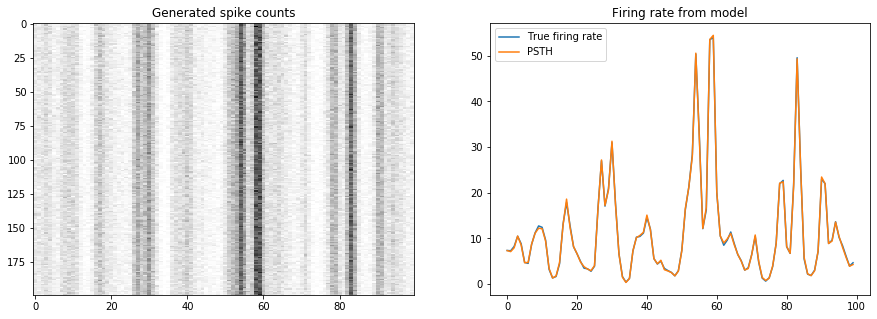

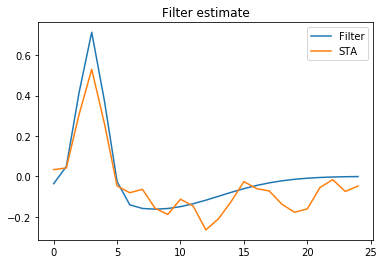

In [36]:
# Sample code

# Make filter, set baseline

# a) Set the filter and baseline values
stim_lags = 25
dt = 1
_filter = make_filter(lags=stim_lags, mu1=3., mu2=8., s1=1., s2=5., eta=.2)
baseline = 2.

# Generate stimulus and responses

# Generate stimulus
stim = np.random.normal(size=100)

#Make repeats of stimulus
stim = np.tile(stim, 200).reshape(200, -1)

# Calculate firing rate
z = convolution_new(_filter, stim) + baseline
r = np.exp(z)
# Simulate from model
y = np.random.poisson(dt * r)

# Plot spike counts, predicted firing rate and PSTH
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Generated spike counts")
ax1.imshow(y, cmap='binary', aspect='auto')

ax2.set_title("Firing rate from model")
ax2.plot(r[0], label="True firing rate")
ax2.plot(y.mean(0), label = "PSTH")
ax2.legend()


# Fast version
from utils import hankel
X = hankel_new(stim_lags, stim)
sta = y.flatten().dot(X) / y.sum()    
plt.figure()
plt.title("Filter estimate")
plt.plot(_filter, label="Filter")
plt.plot(sta, label = "STA")
plt.legend()

### Issues with the Hankel matrix

Questions:  

Why was that an issue here?  
Is this a realistic setting?


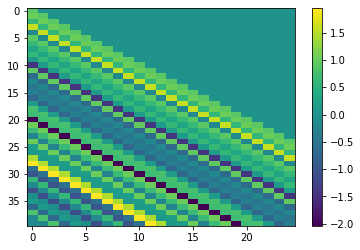

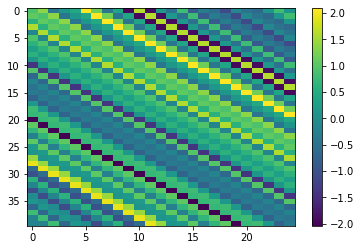

In [5]:
hank_old = hankel(stim_lags, stim)

plt.figure()
plt.imshow(hank_old[0:40,:], aspect='auto')
plt.colorbar()
plt.figure()
plt.imshow(hank_old[-100:-60,:], aspect='auto')
plt.colorbar()

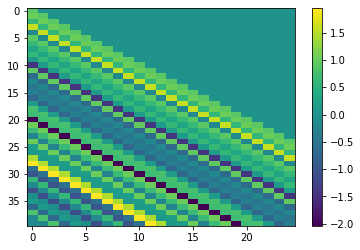

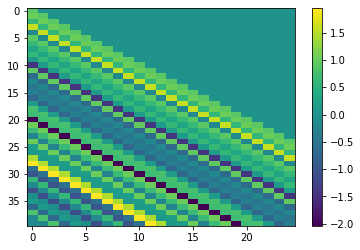

In [6]:
hank = hankel_new(stim_lags, stim)

plt.figure()
plt.imshow(hank[0:40,:], aspect='auto')
plt.colorbar()
plt.figure()
plt.imshow(hank[-100:-60,:], aspect='auto')
plt.colorbar()

### Old version we provided

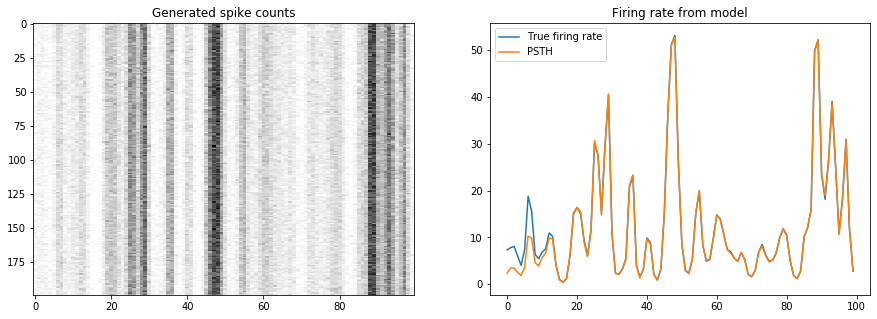

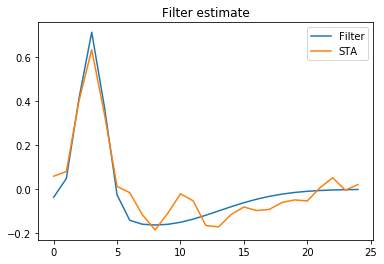

In [37]:
# Sample code

# Make filter, set baseline

# a) Set the filter and baseline values
stim_lags = 25
dt = 1
_filter = make_filter(lags=stim_lags, mu1=3., mu2=8., s1=1., s2=5., eta=.2)
baseline = 2.

# Generate stimulus and responses

# Generate stimulus
stim = np.random.normal(size=100)

#Make repeats of stimulus
stim = np.tile(stim, 200).reshape(200, -1)

# Calculate firing rate
z = convolution(_filter, stim) + baseline
r = np.exp(z)
# Simulate from model
y = np.random.poisson(dt * r)

# Plot spike counts, predicted firing rate and PSTH
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Generated spike counts")
ax1.imshow(y, cmap='binary', aspect='auto')

ax2.set_title("Firing rate from model")
ax2.plot(r[0], label="True firing rate")
ax2.plot(y.mean(0), label = "PSTH")
ax2.legend()


# Fast version
X = hankel(stim_lags, stim)
sta = y.flatten().dot(X) / y.sum()    
plt.figure()
plt.title("Filter estimate")
plt.plot(_filter, label="Filter")
plt.plot(sta, label = "STA")
plt.legend()

### We will use the old implementation of the hankel matrix for the rest of this exercise

In [8]:
def concat_params(_filter, baseline):
    """make appending w and b more explicit
    simpler preimplemented:
    np.append(_filter, baseline)
    """
    params = np.zeros(len(_filter)+1)
    params[:-1]=_filter
    params[-1]=baseline
    return params

def summed_factorial(responses, log = True):
    """ sum up the factorial of  a vector or matrix 
        set logarithm flag
    """
    responses = np.array(responses)
    responses = responses.flatten()
    responses = factorial(responses)
    if log:
        responses = np.log(responses)
    return np.sum(responses)

In [9]:
#c) Write down a Python function that takes as input the LNP parameters (filter and baseline), the groundtruth stimulus and the groundtruth responses, and returns the log likelihood of the model.

def log_likelihood(params, stimulus, responses, dt = 1):
    """ log likelihood of the model    
    """
    assert responses.shape == stimulus.shape
    filter_array, baseline = params[:-1], params[-1]
    
    # Flatten response
    stimulus = stimulus.flatten()
    responses = responses.flatten()
    
    # Construct hankel to implement convolution
    hank = hankel(len(filter_array), stimulus)
    
    # calculate z 
    z = hank.dot(filter_array) + baseline
    # non linearity
    
    log_lik = np.sum(responses * (z + np.log(dt)) - np.exp(z) * dt) - summed_factorial(responses, log = True)
    return log_lik

In [10]:
params = np.append(_filter, baseline)
log_lik = log_likelihood(params, stim, y, dt = 1)
print(log_lik)

cost_ll = cost(params, stim, y, dt = 1)
print(cost_ll)

-48001.585572840646
-48001.58557284066



d) Get the MLE estimate of the parameters using the minimize_mle() method from utils.py

e) Compare the MLE estimate of the filter to the STA and the true filter. 


In [11]:
def neg_log_likelihood(params, stimulus, responses, dt = 1):
    """ return negative log likelihood"""
    return -log_likelihood(params, stimulus, responses, dt = dt)

neg_log_likelihood(np.append(_filter, baseline), stim, y, dt = 1)

48001.585572840646

In [14]:
def minimize(stimulus, response, stim_lags, dt):
    """Returns the ML estimate of the parameters of a linear-nonlinear Poisson model.
    Parameters:
    stimulus : vector / matrix of floats containing the input stimulus.
    response : vector / matrix of floats containing the responses of the neuron to the stimulus. Should be of same shape as the stimulus.
    dt : float value containing size of timebins in s.
    
    Returns:
    _filter : vector of floats. ML estimate of the convolutional filter.
    baseline : float value. ML estimate of the baseline offset. 
    """
    init = np.zeros(stim_lags + 1)
    params = scipy_minimize(neg_log_likelihood, init, args=(stimulus, response, dt), jac=False).x
    return params[:-1], params[-1]

In [12]:
w_est, b_est = minimize_mle(stim, y, stim_lags, dt)

In [15]:
w_est, b_est = minimize(stim, y, stim_lags, dt)

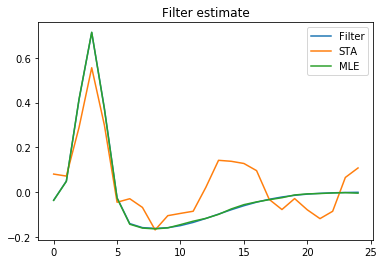

In [16]:
plt.figure()
plt.title("Filter estimate")
plt.plot(_filter, label="Filter")
plt.plot(sta, label = "STA")
plt.plot(w_est, label = "MLE")

plt.legend()


f) Simulate data from the LNP model, using the 
1. the STA estimate as the filter parameters and the baseline you estimated by averaging across the complete PSTH
2. the MLE estimate of the parameters

Compare the mean and variance of the spike trains from 1. and 2. with that of the real spike trains.
Find a suitable way to visualise this comparison. 


In [17]:
stim_lags = 25
stim = np.random.normal(size=100)
#Make repeats of stimulus

stim = np.tile(stim, 200).reshape(200, -1)

dt = 1
baseline = 2.


_filter = make_filter(lags=stim_lags, mu1=3., mu2=8., s1=1., s2=5., eta=.2)

In [18]:
# Calculate firing rate
z = convolution(_filter, stim) + baseline
r = np.exp(z)
# Simulate from model
y = np.random.poisson(dt * r)

In [19]:
# STA
baseline_estimate = np.mean(np.log(y.mean(0)))
#baseline_estimate = np.log(y.mean(0)[-1]) -> WHY is this approach no longer applicable here?
print("Baseline estimate: %f" %baseline_estimate)
X = hankel(stim_lags, stim)
sta = y.flatten().dot(X) / y.sum()    

z_sta = convolution(sta, stim) + baseline_estimate
r_sta = np.exp(z_sta)
# Simulate from model
y_sta = np.random.poisson(dt * r_sta)

Baseline estimate: 2.002955


In [20]:
#from scipy.optimize import minimize as scipy_minimize
w_est, b_est = minimize_mle(stim, y, stim_lags, dt)
print("Baseline MLE estimate: %f" %b_est)

# MLE
z_mle = convolution(w_est, stim) + b_est
r_mle = np.exp(z)
# Simulate from model
y_mle = np.random.poisson(dt * r_mle)

Baseline MLE estimate: 2.001914


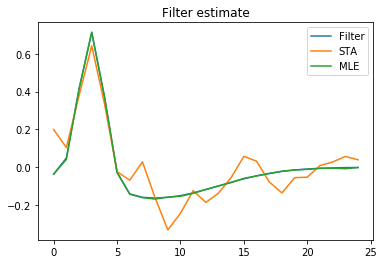

In [21]:
plt.figure()
plt.title("Filter estimate")
plt.plot(_filter, label="Filter")
plt.plot(sta, label = "STA")
plt.plot(w_est, label = "MLE")
plt.legend()

In [24]:
# MLE
mean_mle = np.mean(y_mle, axis=1)
var_mle =np.var(y_mle, axis=1)
# STA
mean_sta = np.mean(y_sta, axis=1)
var_sta =np.var(y_sta, axis=1)
# GROUND TRUTH
mean_gt = np.mean(y, axis=1)
var_gt =np.var(y, axis=1)

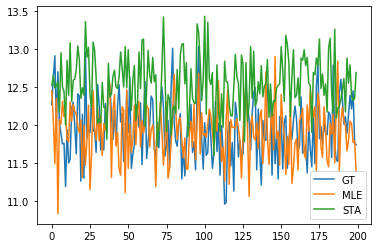

In [34]:
plt.plot(mean_gt, label='GT')
plt.plot(mean_mle, label='MLE')
plt.plot(mean_sta, label='STA')
plt.legend()

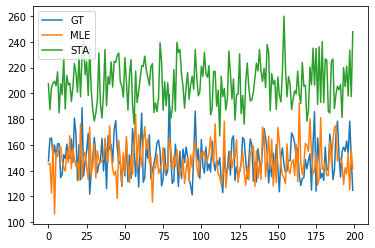

In [35]:
plt.plot(var_gt, label='GT')
plt.plot(var_mle, label='MLE')
plt.plot(var_sta, label='STA')
plt.legend()

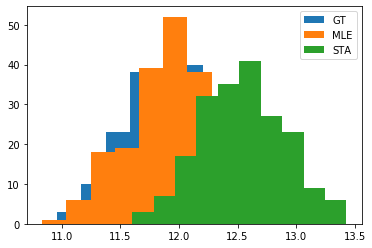

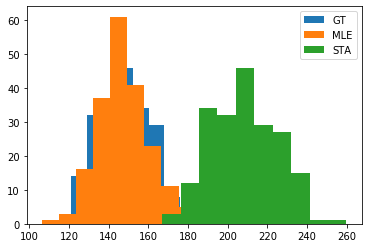

In [33]:
plt.hist(mean_gt, label='GT')
plt.hist(mean_mle, label='MLE')
plt.hist(mean_sta, label='STA')
plt.legend()
plt.figure()
plt.hist(var_gt, label='GT')
plt.hist(var_mle, label='MLE')
plt.hist(var_sta, label='STA')
plt.legend()

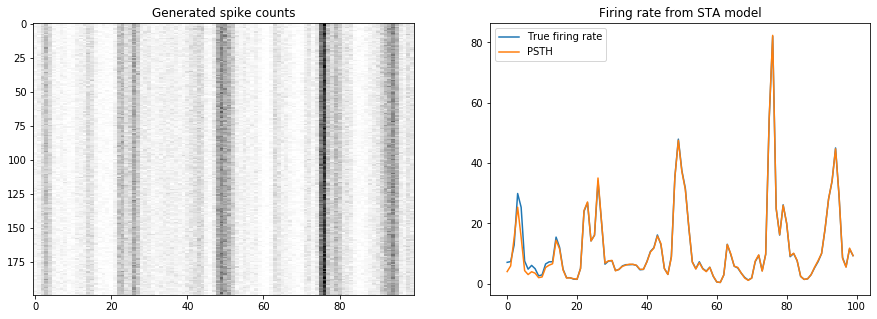

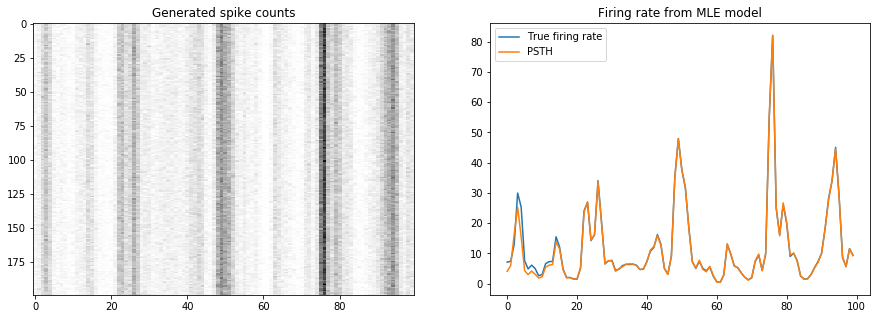

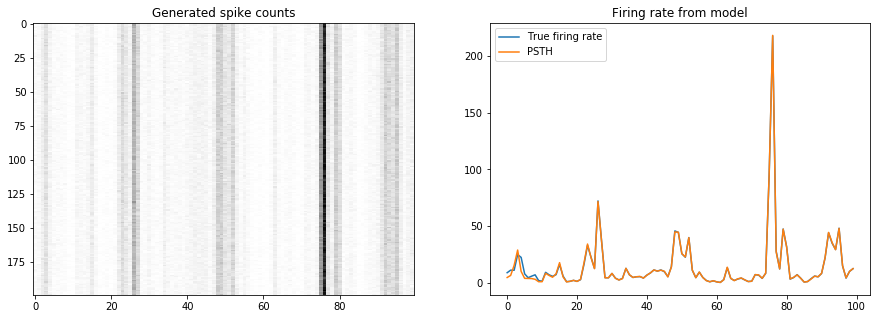

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Generated spike counts")
ax1.imshow(y, cmap='binary', aspect='auto')

ax2.set_title("Firing rate from STA model")
ax2.plot(r[0], label="True firing rate")
ax2.plot(y.mean(0), label = "PSTH")
ax2.legend()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Generated spike counts")
ax1.imshow(y_mle, cmap='binary', aspect='auto')

ax2.set_title("Firing rate from MLE model")
ax2.plot(r_mle[0], label="True firing rate")
ax2.plot(y_mle.mean(0), label = "PSTH")
ax2.legend()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Generated spike counts")
ax1.imshow(y_sta, cmap='binary', aspect='auto')

ax2.set_title("Firing rate from model")
ax2.plot(r_sta[0], label="True firing rate")
ax2.plot(y_sta.mean(0), label = "PSTH")
ax2.legend()

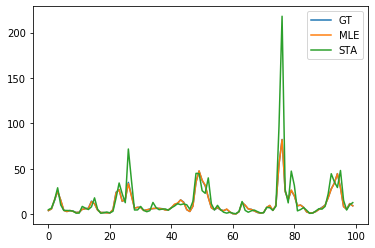

In [27]:
plt.plot(y.mean(0), label = "GT")
plt.plot(y_mle.mean(0), label = "MLE")
plt.plot(y_sta.mean(0), label = "STA")
plt.legend()

### Part 4:   Fitting an Linear Nonlinear Poisson (LNP) model with maximum a posteriori (MAP)

We can maximise the likelihood of a generalized linear model (GLM) to estimate the parameters that best fit a given dataset. However, sometimes, we want to incorporate prior assumptions about the parameters while fitting them e.g. smoothness. 
For an LNP model with a parameters $\boldsymbol{\omega}$ and input stimulus $\mathbf{x}_{1:T}$, the likelihood of the output spike train $y_{1:T}$ is:

$p(y_{1:T} | \boldsymbol{\omega}, \mathbf{x}_t) = \underset{t=1}{\overset{T}{\prod}}\frac{(r_t \Delta t)^{y_t}\exp^{-r_t \Delta t}}{y_t !}$


$r_t$ is the predicted firing rate in timebins $t$ from the LNP model, assuming the canonical $\exp()$ nonlinearity:

$r_t = \exp(\boldsymbol{\omega} * \mathbf{x}_{t-k\text{ }:\text{ }t})$

In order to incorporate prior assumptions about the parameters $\boldsymbol{\omega}$, we _assume_ a prior distribution  $p(\boldsymbol{\omega})$ over $\boldsymbol{\omega}$.


From Bayes' rule, we know that:

$p(\boldsymbol{\omega}|y_{1:T}, \mathbf{x}_{1:T})\text{    }p(y_{1:T} | \mathbf{x}_{1:T}) = p(y_{1:T}| \boldsymbol{\omega}, \mathbf{x}_{1:T})\text{    }p(\boldsymbol{\omega})$ 

$\begin{align*}
\implies p(\boldsymbol{\omega}|y_{1:T}, \mathbf{x}_{1:T}) &\propto p(y_{1:T}| \boldsymbol{\omega}, \mathbf{x}_{1:T})\text{    }p(\boldsymbol{\omega})\\
\text{posterior  } &\propto \text{likelihood x prior}
\end{align*}$


Quick reminder:  

$p({\omega},y) = p({\omega}|y) p(y)$  
$p({\omega},y) = p(y|{\omega}) p({\omega})$  
$p({\omega}|y) = \frac{p(y|{\omega}) p({\omega})}{p(y)}$  


Hence, by multiplying the prior to the likleihood and calculating $\log$ of this equation, we now maximise the log posterior of the parameters given the data:

$
\begin{align}
\log p(\boldsymbol{\omega}|y_{1:T}, \mathbf{x}_{1:T}) &= \log(p(y_{1:T}| \boldsymbol{\omega}, \mathbf{x}_{1:T}) + \log p(\boldsymbol{\omega}) + C\\
  &= \underset{t=1}{\overset{T}{\sum}}\Big(y_t \log r_t \Delta t - r_t \Delta t - \log(y_t !)\Big) + \log p(\boldsymbol{\omega}) + C
\end{align}$

Note that if the prior is also concave, then the log posterior is guaranteed to be concave, and so, there is a single global optimum with respect to the parameters $\boldsymbol{\omega}$.

Additionally, we can use the second derivative of the log posterior (aka the Hessian), to calculate the error bars (or the posterior variance $\Sigma_{\text{post}}$) of the parameters using the Laplace approximation (see References).

$\Sigma_{\text{post}} = -\big(\nabla\nabla \log p(\boldsymbol{\omega}_{\text{MAP}}|y_{1:T}, \mathbf{x}_{1:T})\big)^{-1}$

**Questions:**

a) Assume that the parameters $\boldsymbol{\omega}$ follow a multivariate Gaussian distribution with mean 0 and the identity matrix as the covariance matrix i.e.:

$\boldsymbol{\omega} \sim \mathcal{N}\big(\boldsymbol{0}, \mathbf{I}\big)$

Write down the log posterior of the LNP model, the gradient of the log posterior with respect to $\boldsymbol{\omega}$

Hint : the log prior is $\underset{k=1}{\overset{K}{\sum}}\boldsymbol{\omega}^2_k$ where $K$ is the length of $\boldsymbol{\omega}$

b) Using a fixed filter and baseline, simulate responses $\mathbf{y}^{real}$ from an LNP model, as in Part 2 of the previous tutorial. Save the response and stimulus values -- these will be our groundtruth (real) dataset.

b) Calculate the STA for these responses

c) Write down a Python function that takes as input the LNP parameters (filter and baseline), the groundtruth stimulus and the groundtruth responses, and returns the 

    i) log likelihood of the model. (Hint : check your function against the log_likelihood() method in utils.py)
    ii) log posterior of the model. (Hint : check your function against the log_posterior() method in utils.py)

d) Get the MLE estimate of the parameters using the minimize_mle() method from utils.py

e) Get the MAP estimate of the parameters using the minimize_map() method fro utils.py

f) Compare the MLE estimate, MAP estimate, the STA and the true filter. 


In [33]:
from utils import make_filter, convolution, minimize_mle, minimize_map, hankel, inv_hessian

In [34]:
# Sample code

# Make filter, set baseline

# a) Set the filter and baseline values
stim_lags = 25
dt = .1
_filter = make_filter(lags=stim_lags, mu1=3., mu2=8., s1=1., s2=5., eta=.2)
baseline = 0.

# Generate stimulus and responses

# Generate stimulus
stim = np.random.normal(size=100)

#Make repeats of stimulus
stim = np.tile(stim, 200).reshape(200, -1)

# Calculate firing rate
z = convolution(_filter, stim) + baseline
r = np.exp(z)
# Simulate from model
y = np.random.poisson(dt * r)


# Calculate the STA
X = hankel(stim_lags, stim)
sta = y.flatten().dot(X) / y.sum()

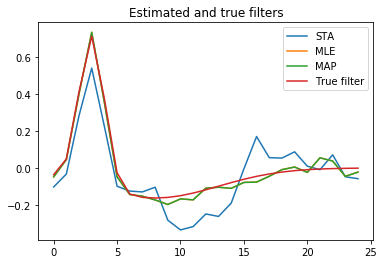

In [35]:
# Call minimize_mle() from utils.py to get MLE estimates
w_mle, b_mle = minimize_mle(stim, y, stim_lags, dt)

# Call minimize_map() from utils.py to get MAP estimates
w_map, b_map = minimize_map(stim, y, stim_lags, dt)

# Plot STA, MLE and MAP estimates for the filter:
plt.title("Estimated and true filters")
plt.plot(sta / np.linalg.norm(sta),  label='STA')
plt.plot(w_mle, label='MLE')
plt.plot(w_map, label="MAP")
plt.plot(_filter, label="True filter")
plt.legend()
plt.show()

### MAP estimate with error bars (Optional)


h) _Optional_ : 
- Calculate the second derivate of the log posterior with repect to the parameters (aka the Hessian). Show that the Hessian of the log posterior is a negative semidefinite matrix. (Hint: a matrix $A$ is negative semidefinite, if for any vector $a$, $a^TXa \leq 0$)

- Write down a function that takes as input the LNP parameters (filter and baseline), the groundtruth stimulus and the groundtruth responses, and returns the inverse of the Hessian. (Hint : check your function against the inv_hessian() method in utils.py)

- Use the inverse obtained from calling the method inv_hessina() to plot errorbars for the MAP estimate of the parameters. (Remember the _variance_ of the parameters is the diagonal of the _negative_ inverse Hessian)

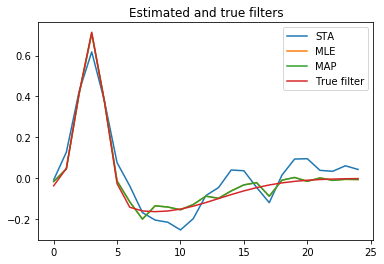

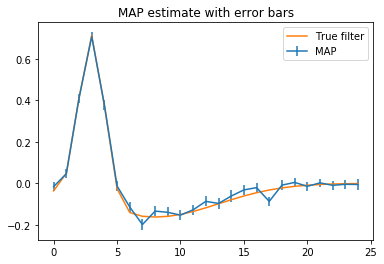

In [39]:
H_filter, H_baseline = inv_hessian(np.append(w_map, b_map), stim, y, dt)
error_filter = np.sqrt( np.diag( - H_filter ) )

plt.title("MAP estimate with error bars")
plt.errorbar(range(stim_lags), w_map, yerr=error_filter, label="MAP")
plt.plot(_filter, label="True filter")
plt.legend()
plt.show()